**1**



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
def data():
    np.random.seed(1000)
    A = np.random.randn(1000, 10)
    x_bar = np.zeros(10)
    for i in range(10):
      if (i+1)%2 == 0:
        x_bar[i] = np.random.uniform(low = i+1, high = i+2)
      else:
        x_bar[i] = np.random.uniform(low = -(i+2), high = -(i+1) )
      x_bar = np.array(x_bar)
      x_bar = x_bar.reshape(10,1)
    epsilon = np.random.randn(1000, 1)
    y = np.add(np.dot(A, x_bar), epsilon)

    return A, x_bar, y

In [3]:
def evalf(A, x, y):
    assert type(x) is np.ndarray
    assert x.shape[0] == 10 and x.shape[1] == 1
    assert type(y) is np.ndarray and len(y) == 1000

    t = np.subtract(np.dot(A,x),y)
    fval = 0.5*np.linalg.norm(t,2)**2
    return fval


In [4]:
A,_,y = data()
x = []
for i in range(10):
  x.append([1])
x = np.array(x)

In [5]:
def evalg(A, x, y):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    assert type(y) is np.ndarray and len(y) == 1000

    t = np.dot(A,x) - y
    grad = np.dot(A.T,t)
    return grad

In [6]:
def evalh(A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    hess = np.matmul(A.T, A)
    return hess

In [7]:
def compute_D_k_newton(A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    d = np.linalg.inv(evalh(A, x))
    return d
def compute_steplength_backtracking_scaled_direction(A, x, y, gradf, D_k, alpha_start, rho, gamma): #add appropriate arguments to the function
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    assert type(y) is np.ndarray and len(y) == 1000
    assert type(gradf) is np.ndarray and len(gradf) == 10
    assert type(alpha_start) is float and alpha_start>=0.
    assert type(rho) is float and rho>=0.
    assert type(gamma) is float and gamma>=0.
    assert type(D_k) is np.ndarray and len(D_k) == 10

    alpha = alpha_start
    p_k = -np.dot(D_k,gradf)
    # while evalf(A, np.add(x, alpha*np.dot(D_k,p)), y) > np.subtract(evalf(A, x, y), gamma*alpha*np.dot(np.dot(D_k,gradf), gradf)):
    while evalf(A, np.add(x,np.multiply(alpha,p_k)),y) > np.multiply(gamma*alpha,np.dot(gradf.T,p_k)) + evalf(A,x,y):
        alpha = rho*alpha

    return alpha

In [8]:
#line search type
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2
CONSTANT_STEP_LENGTH = 3

In [9]:
# BFGS method
def find_minimizer_BFGS(start_x, A, y, tol, line_search_type, *args):
    assert type(start_x) is np.ndarray
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1
    assert type(tol) is float and tol>=0

    x = start_x
    g_x = evalg(A, x, y)

    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    B = np.identity(10)
    x_array = [x]
    f_array = [evalf(A, x,y)]

    while (np.linalg.norm(g_x) > tol):
        p = -np.dot(B, g_x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            d_k = B
            step_length = compute_steplength_backtracking_scaled_direction(A, x, y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('check!')


        x_next = np.add(x, np.multiply(step_length,p))
        s_k = x_next - x
        y_k = evalg(A, x_next,y) - g_x
        mu_k = 1.0/np.dot(y_k.T, s_k)
        temp = (np.identity(10) - np.multiply(mu_k,np.outer(y_k, s_k.T)))
        B = np.dot(temp.T, np.dot(B, temp)) + np.multiply(mu_k, np.outer(s_k, s_k.T))
        k += 1
        x = x_next
        g_x = evalg(A, x, y)

        x_array.append(x)
        f_array.append(evalf(A, x, y))



    return x_array, f_array, k

**3)**

In [10]:
# Newton's method
def find_minimizer_Newtonmethod(start_x, A, y, tol, line_search_type, *args):
    assert type(start_x) is np.ndarray
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1
    assert type(tol) is float and tol>=0

    x = start_x
    g_x = evalg(A, x, y)

    x_array = [x]
    f_array = [evalf(A, x,y)]
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    while (np.linalg.norm(g_x) > tol):
        d_k = compute_D_k_newton(A, x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(A, x, y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('Line search type unknown. Please check!')


        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x)))
        k += 1
        g_x = evalg(A, x, y)
        x_array.append(x)
        f_array.append(evalf(A, x,y))


    return x_array, f_array, k

In [11]:
A, x_bar, y = data()
my_start_x = []
for i in range(10):
  my_start_x.append([0])
my_start_x=np.array(my_start_x)

In [12]:
my_tol= 1e-4
alpha_start = 0.99
rho = 0.5
gamma = 0.5

In [13]:
#Newton's method with backtracking search
start_time = timer()
x_array_newton, f_array_newton, iters_opt_newton = find_minimizer_Newtonmethod(my_start_x, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
end_time = timer()
times_newton = end_time - start_time
print(f"\nResults obtained from Newton method (with backtracking)\nMinimizer: {x_array_newton[-1]},\nFinal Objective function value: {f_array_newton[-1]},\nIterations taken to terminate: {iters_opt_newton}\n")
print('------------------------------------------------------------------------')
print(f'Actual x_bar: {x_bar}\n')
print(f"Time taken to find minimizer by Newton's method: {times_newton}")
print('------------------------------------------------------------')
x_opt = x_array_newton[-1]
plot_x = []
for i in range(len(x_array_newton)):
    plot_x.append(np.log(np.linalg.norm(x_array_newton[i] - x_opt)))


Results obtained from Newton method (with backtracking)
Minimizer: [[-1.04982253]
 [ 2.95189743]
 [-3.34298192]
 [ 4.60956007]
 [-5.71176195]
 [ 6.89877618]
 [-7.62879358]
 [ 8.16821112]
 [-9.22221199]
 [10.05669293]],
Final Objective function value: 505.647329524551,
Iterations taken to terminate: 5

------------------------------------------------------------------------
Actual x_bar: [[-1.06258705]
 [ 2.94307072]
 [-3.34150552]
 [ 4.58252615]
 [-5.75947573]
 [ 6.93512469]
 [-7.61893094]
 [ 8.16818187]
 [-9.2179964 ]
 [10.00022174]]

Time taken to find minimizer by Newton's method: 0.030174813000002132
------------------------------------------------------------


<ipython-input-13-f3d063938955>:14: RuntimeWarning: divide by zero encountered in log
  plot_x.append(np.log(np.linalg.norm(x_array_newton[i] - x_opt)))


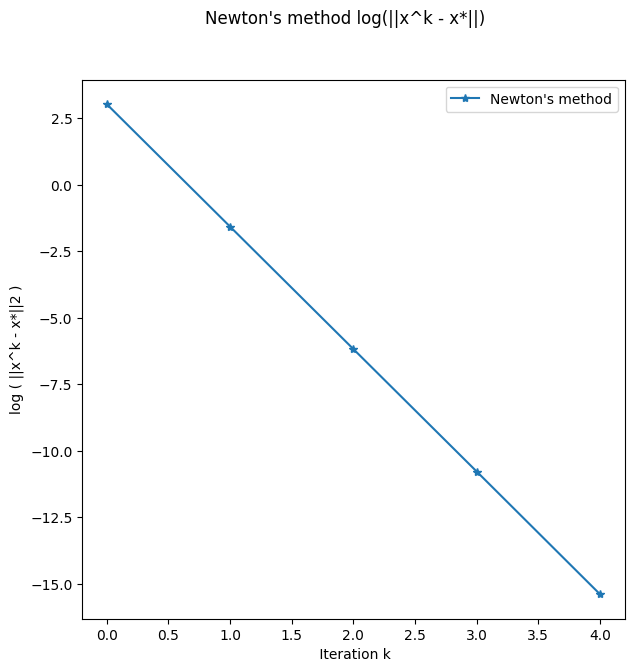

In [14]:
fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle("Newton's method log(||x^k - x*||)")
ax.plot(np.arange(len(x_array_newton)), plot_x, '*-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( ||x^k - x*||2 )")
ax.legend()

<ipython-input-15-e308e926057a>:4: RuntimeWarning: divide by zero encountered in log
  plot_fx.append(np.log(np.abs(f_array_newton[i] - f_opt)))


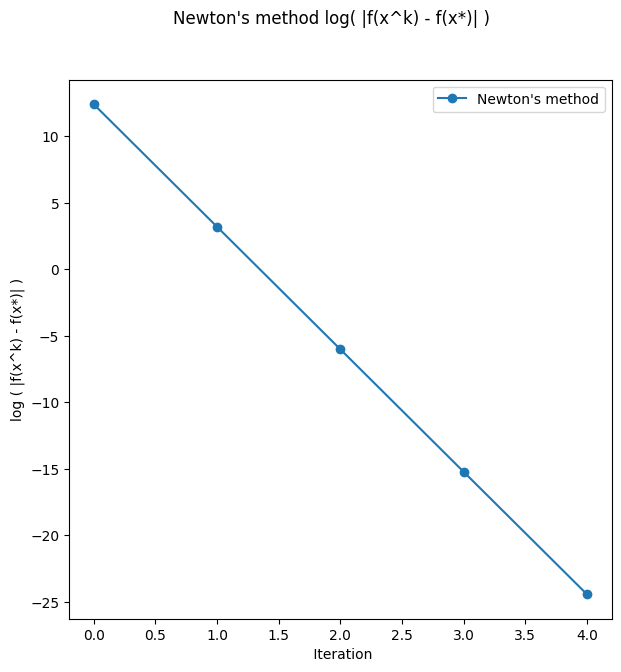

In [15]:
f_opt = f_array_newton[-1]
plot_fx = []
for i in range(len(f_array_newton)):
    plot_fx.append(np.log(np.abs(f_array_newton[i] - f_opt)))

fig2, ax = plt.subplots(1,1, figsize = (7,7))
fig2.suptitle("Newton's method log( |f(x^k) - f(x*)| )")
ax.plot(np.arange(len(f_array_newton)), plot_fx, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration")
ax.set_ylabel("log ( |f(x^k) - f(x*)| )")
ax.legend()

**3.**
Newton's Method with backtracking line search

α=0.99,ρ=0.5,γ=0.5

Let $x^*$ denote the final optimal solution yielded by our algorithm.

The values of $x^*$ are as follows:
\[
\begin{bmatrix}
-1.04982253 \\
2.95189743 \\
-3.34298192 \\
4.60956007 \\
-5.71176195 \\
6.89877618 \\
-7.62879358 \\
8.16821112 \\
-9.22221199 \\
10.05669293
\end{bmatrix}
\]

Similarly, the values of $\bar{x}$ are:
\[
\begin{bmatrix}
-1.06258705 \\
2.94307072 \\
-3.34150552 \\
4.58252615 \\
-5.75947573 \\
6.93512469 \\
-7.61893094 \\
8.16818187 \\
-9.2179964 \\
10.00022174
\end{bmatrix}
\]

Both $f(x^*)$ and $f(\bar{x})$ are computed to be $505.647329524551$.

With a precision tolerance, the values of $x^*$ and $\bar{x}$ are practically indistinguishable.

Likewise, $f(x^*)$ and $f(\bar{x})$ exhibit minimal deviation, demonstrating the close approximation between the two.

The convergence behavior appears consistent, displaying a quadratic convergence rate for both the iterates and the objective function values. Initially, the algorithm converges rapidly, gradually transitioning to a slower convergence rate over time.


In [16]:
my_start_x = []
for i in range(10):
  my_start_x.append([0])
my_start_x=np.array(my_start_x)
my_tol= 1e-4
alpha_start = 0.99
rho = 0.5
gamma = 0.5

**4)**

In [17]:
start_time = timer()
x_array_bfgs, f_array_bfgs, iters_opt_bfgs = find_minimizer_BFGS(my_start_x, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
end_time = timer()
time_bfgs = end_time - start_time
print(f"\nResults obtained from BFGS method (with backtracking)\nMinimizer: {x_array_bfgs[-1]},\nFinal Objective function value: {f_array_bfgs[-1]},\nIterations taken to terminate: {iters_opt_bfgs}\n")
print('---------------------------------------------------------------')
print(f'Actual x_bar: {x_bar}\n')
print(f"Time taken to find minimizer by BFGS method: {time_bfgs}")
print('----------------------------------------------------------------')




Results obtained from BFGS method (with backtracking)
Minimizer: [[-1.04982253]
 [ 2.95189743]
 [-3.34298192]
 [ 4.60956007]
 [-5.71176195]
 [ 6.89877618]
 [-7.62879358]
 [ 8.16821111]
 [-9.22221199]
 [10.05669293]],
Final Objective function value: 505.64732952455125,
Iterations taken to terminate: 18

---------------------------------------------------------------
Actual x_bar: [[-1.06258705]
 [ 2.94307072]
 [-3.34150552]
 [ 4.58252615]
 [-5.75947573]
 [ 6.93512469]
 [-7.61893094]
 [ 8.16818187]
 [-9.2179964 ]
 [10.00022174]]

Time taken to find minimizer by BFGS method: 0.06493151600000147
----------------------------------------------------------------


<ipython-input-18-972d4bed583c>:4: RuntimeWarning: divide by zero encountered in log
  plot_x_bfgs.append(np.log(np.linalg.norm(x_array_bfgs[i] - x_opt)))


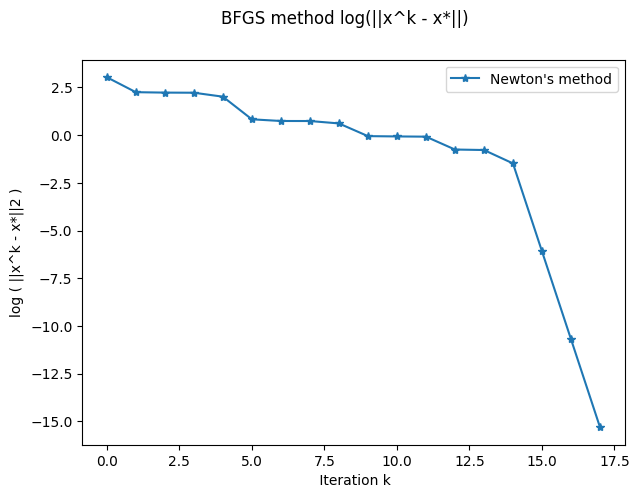

In [18]:
x_opt = x_array_bfgs[-1]
plot_x_bfgs = []
for i in range(len(x_array_bfgs)):
    plot_x_bfgs.append(np.log(np.linalg.norm(x_array_bfgs[i] - x_opt)))

fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("BFGS method log(||x^k - x*||)")
ax.plot(np.arange(len(x_array_bfgs)), plot_x_bfgs, '*-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( ||x^k - x*||2 )")
ax.legend()

<ipython-input-19-37a90d69498c>:4: RuntimeWarning: divide by zero encountered in log
  plot_fx_bfgs.append(np.log(np.abs(f_array_bfgs[i] - f_opt_bfgs)))


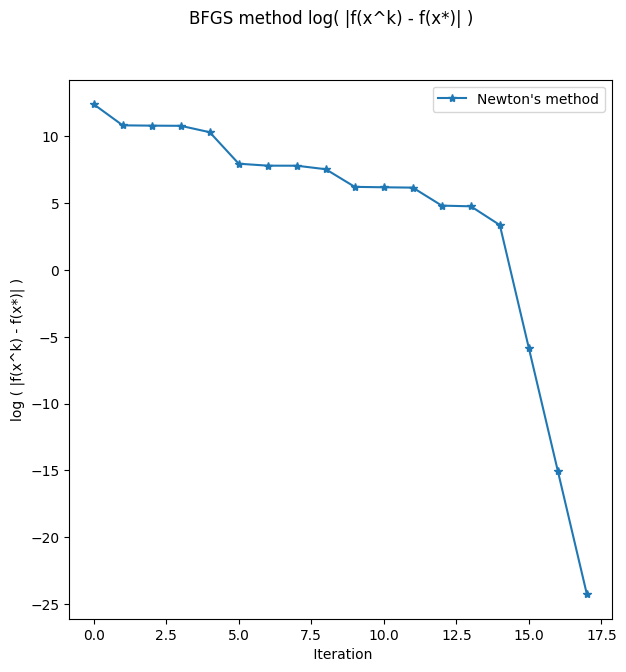

In [19]:
f_opt_bfgs = f_array_bfgs[-1]
plot_fx_bfgs = []
for i in range(len(f_array_bfgs)):
    plot_fx_bfgs.append(np.log(np.abs(f_array_bfgs[i] - f_opt_bfgs)))

fig2, ax = plt.subplots(1,1, figsize = (7,7))
fig2.suptitle("BFGS method log( |f(x^k) - f(x*)| )")
ax.plot(np.arange(len(f_array_bfgs)), plot_fx_bfgs, '*-', label = "Newton's method")
ax.set_xlabel(" Iteration")
ax.set_ylabel("log ( |f(x^k) - f(x*)| )")
ax.legend()

#4
Let \( x* \) represent the final optimal solution obtained from our algorithm.

The values of \( x* \) are as follows:
\[
\begin{bmatrix}
-1.04982253 \\
2.95189743 \\
-3.34298192 \\
4.60956007 \\
-5.71176195 \\
6.89877618 \\
-7.62879358 \\
8.16821111 \\
-9.22221199 \\
10.05669293
\end{bmatrix}
\]

Similarly, the values of \( \bar{x} \) are:
\[
\begin{bmatrix}
-1.06258705 \\
2.94307072 \\
-3.34150552 \\
4.58252615 \\
-5.75947573 \\
6.93512469 \\
-7.61893094 \\
8.16818187 \\
-9.2179964 \\
10.00022174
\end{bmatrix}
\]

The objective function value at \( x* \) and x is computed to be \( 505.64732952455125 \).

Both \( x* \) and x exhibit minimal deviation from each other within the tolerance precision.

Likewise, the objective function values at \( x* \) and x demonstrate negligible difference within the tolerance precision.

The convergence rate remains consistent and Q-quadratic for both the iterates and the objective function values. Initially, the algorithm converges rapidly, but it gradually transitions to a slower convergence rate over time. In the early iterations, slight perturbations are observed, yet thereafter, rapid convergence ensues.


5.

Both methods exhibited quadratic convergence. Newton's method demonstrated a faster convergence rate compared to BFGS method, which is expected as BFGS utilizes an approximation of the Hessian matrix. Initially, BFGS exhibited slower convergence and made some tentative steps compared to Newton's method. However, both methods ultimately converged to the same objective value and optimum.
